# 02 – Light Classification

In this notebook we:
1. Load the consolidated big table
2. Compute solar altitude for each sensor-hour
3. Classify hours into:
   - Daylight (> 0°)
   - Darkness (< -6°)
   - Twilight (excluded)
4. Create binary variable `Dark`
5. Produce summary statistics and validation plots


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BIG_PATH = "../data/mdm2_data_files/big_table.csv"

big = pd.read_csv(BIG_PATH)
big["datetime"] = pd.to_datetime(big["datetime"], utc=True, errors="coerce")
big = big.dropna(subset=["datetime"])

print("Rows:", len(big))
print("Sensors:", big["sensor_id"].nunique())
big.head()


/Users/shavarshmelikyan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Rows: 509472
Sensors: 58


,ped,car,cyc,sensor_id,datetime,hour,date_only,dow,longitude,latitude
0,413,381,9,1,2024-01-01 00:00:00+00:00,0,2024-01-01,0,-2.591538,51.453815
1,402,489,10,1,2024-01-01 01:00:00+00:00,1,2024-01-01,0,-2.591538,51.453815
2,421,473,10,1,2024-01-01 02:00:00+00:00,2,2024-01-01,0,-2.591538,51.453815
3,370,419,4,1,2024-01-01 03:00:00+00:00,3,2024-01-01,0,-2.591538,51.453815
4,132,123,2,1,2024-01-01 04:00:00+00:00,4,2024-01-01,0,-2.591538,51.453815


In [2]:
def solar_altitude_deg(dt_utc, lat_deg, lon_deg):
    """
    Approximate solar altitude (degrees) for UTC datetimes at fixed lat/lon.
    Accurate enough for day/dark/twilight classification.
    """
    dts = pd.to_datetime(dt_utc, utc=True)

    n = dts.dt.dayofyear.to_numpy()
    hour = (dts.dt.hour + dts.dt.minute/60.0 + dts.dt.second/3600.0).to_numpy()

    lat = np.deg2rad(lat_deg)
    gamma = 2.0*np.pi/365.0 * (n - 1 + (hour - 12)/24.0)

    # declination (radians)
    decl = (0.006918
            - 0.399912*np.cos(gamma) + 0.070257*np.sin(gamma)
            - 0.006758*np.cos(2*gamma) + 0.000907*np.sin(2*gamma)
            - 0.002697*np.cos(3*gamma) + 0.00148*np.sin(3*gamma))

    # equation of time (minutes)
    eqtime = 229.18*(0.000075
                     + 0.001868*np.cos(gamma) - 0.032077*np.sin(gamma)
                     - 0.014615*np.cos(2*gamma) - 0.040849*np.sin(2*gamma))

    # true solar time (minutes), dt is UTC so tz=0
    tst = (hour*60.0 + eqtime + 4.0*lon_deg) % 1440.0

    # hour angle (radians)
    ha = np.deg2rad((tst/4.0) - 180.0)

    cos_zen = np.sin(lat)*np.sin(decl) + np.cos(lat)*np.cos(decl)*np.cos(ha)
    cos_zen = np.clip(cos_zen, -1.0, 1.0)

    zen = np.arccos(cos_zen)
    alt = np.rad2deg(np.pi/2 - zen)

    return alt


In [3]:
big = big.sort_values(["sensor_id", "datetime"]).reset_index(drop=True)
big["solar_altitude_deg"] = np.nan

for sid, g in big.groupby("sensor_id", sort=False):
    lat = float(g["latitude"].iloc[0])
    lon = float(g["longitude"].iloc[0])
    big.loc[g.index, "solar_altitude_deg"] = solar_altitude_deg(g["datetime"], lat, lon)

big[["sensor_id", "datetime", "solar_altitude_deg"]].head()


,sensor_id,datetime,solar_altitude_deg
0,1,2024-01-01 00:00:00+00:00,-61.529806
1,1,2024-01-01 01:00:00+00:00,-60.225898
2,1,2024-01-01 02:00:00+00:00,-54.953852
3,1,2024-01-01 03:00:00+00:00,-47.266506
4,1,2024-01-01 04:00:00+00:00,-38.404055


In [4]:
alt = big["solar_altitude_deg"]

big["light_class"] = np.where(alt > 0, "daylight",
                       np.where(alt < -6, "darkness", "twilight"))

lit = big[big["light_class"] != "twilight"].copy()
lit["Dark"] = (lit["light_class"] == "darkness").astype(int)

lit["hour"] = lit["datetime"].dt.hour
lit["month"] = lit["datetime"].dt.month


In [5]:
total = len(big)
day = int((big["light_class"]=="daylight").sum())
dark = int((big["light_class"]=="darkness").sum())
tw = int((big["light_class"]=="twilight").sum())

print("\n" + "="*70)
print("RESULTS: LIGHT CLASSIFICATION SUMMARY".center(70))
print("="*70)
print(f"Total rows in big table:        {total:,}")
print(f"Daylight rows:                  {day:,}")
print(f"Darkness rows:                  {dark:,}")
print(f"Twilight rows (excluded):       {tw:,}")
print(f"Rows kept (daylight+darkness):  {len(lit):,}")
print("="*70 + "\n")



                RESULTS: LIGHT CLASSIFICATION SUMMARY                 
Total rows in big table:        509,472
Daylight rows:                  255,245
Darkness rows:                  223,220
Twilight rows (excluded):       31,007
Rows kept (daylight+darkness):  478,465



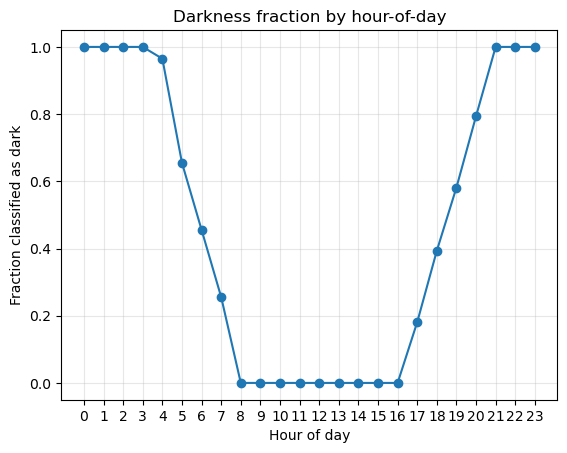

In [7]:
# Ensure hour is clean int 0..23
lit["hour"] = lit["datetime"].dt.hour.astype(int)

# Fraction dark by hour, sorted
hour_dark_frac = (
    lit.groupby("hour")["Dark"]
    .mean()
    .sort_index()
    .dropna()
)

x = hour_dark_frac.index.to_numpy(dtype=float)
y = hour_dark_frac.to_numpy(dtype=float)

plt.figure()
plt.plot(x, y, marker="o")
plt.xticks(range(0, 24))
plt.xlabel("Hour of day")
plt.ylabel("Fraction classified as dark")
plt.title("Darkness fraction by hour-of-day")
plt.grid(True, alpha=0.3)
plt.show()


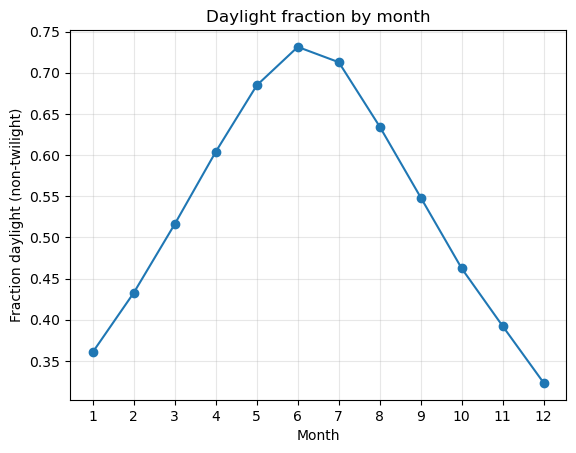

In [8]:
lit["month"] = lit["datetime"].dt.month.astype(int)

month_day_frac = (
    (lit["light_class"]=="daylight")
    .groupby(lit["month"])
    .mean()
    .sort_index()
)

x = month_day_frac.index.to_numpy(dtype=float)
y = month_day_frac.to_numpy(dtype=float)

plt.figure()
plt.plot(x, y, marker="o")
plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Fraction daylight (non-twilight)")
plt.title("Daylight fraction by month")
plt.grid(True, alpha=0.3)
plt.show()


In [10]:
OUT_PATH = "../data/mdm2_data_files/lit_table.csv"
lit.to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH)
print("Rows saved:", len(lit))

Saved: ../data/mdm2_data_files/lit_table.csv
Rows saved: 478465


<div style="font-size:20px; line-height:1.4">
<b>Results: Light classification sanity check</b><br>
The fraction of hours classified as dark is near 1 during late-night hours (roughly 22:00–04:00),
near 0 during daytime hours (roughly 08:00–16:00), and transitions smoothly during morning/evening.
This confirms that solar-altitude-based classification is behaving as expected and is suitable for
subsequent modelling and case–control analysis.
</div>
